In [1]:
import glob
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from tqdm.notebook import tqdm
from skbio.stats.distance import permanova
from scipy.spatial import distance
from skbio import DistanceMatrix
from gemelli.ctf import ctf
from gemelli.joint_ctf import joint_ctf
from gemelli.preprocessing import clr_transformation

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (#accuracy_score, precision_score, recall_score, 
                             roc_curve, auc, average_precision_score)

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def subject_trajectories(table,
                         #individual_loadings,
                         feature_loadings, 
                         #temporal_loadings,
                         component, modality, zoom=True, 
                         quantile=0.95, pseudocount=0):
    # get the loadings
    #sloadings = individual_loadings[modality][component]
    floadings = feature_loadings[modality][component]
    #tloadings = temporal_loadings[modality][component]
    
    table_df = table.to_dataframe()

    if zoom:
        #get top and bottom loading quantiles
        top_q = floadings.quantile(quantile)
        bottom_q = floadings.quantile(1-quantile)
        top_fts = floadings[floadings >= top_q].index
        bottom_fts = floadings[floadings <= bottom_q].index
        
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount

        beta_l = np.log(num).values - np.log(denom).values
        beta_l = pd.DataFrame(beta_l, index=num.index, 
                              columns=[component])
    else:
        #calculate trajectories
        pass
        # y = []
        # for i, (individual_id, m) in enumerate(table.items()):
        #     y.append(np.concatenate(m.T.values))
        #     phi_ = phi_hat[ti[i]]
        #     new_m = np.outer(b_hat, phi_.T)
        #     new_m = a_hat[i] * new_m
        #     table_mod[individual_id] -= (lambda_coeff * new_m)
        #     residual_mod.append(table_mod[individual_id]**2)
        # residual_mod = np.sum(np.concatenate(residual_mod, axis=1))
        # y = np.concatenate(y)
        
    return beta_l, top_fts, bottom_fts

In [38]:
# load filtered tables
body_site = 'Baby-Feces'
mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
bt = load_table('../data/%s/table-filtered.biom' % body_site)

In [39]:
#remove CSseed babies
mf = mf[mf.birth_mode_ms != 'CSseed']
mf.birth_mode_ms.value_counts()

Vag    741
CS     366
Name: birth_mode_ms, dtype: int64

In [40]:
for col in mf.columns:
    print(col, '\n', mf[col].value_counts())
    print()

seqcount 
 10405.0     2
10755.0     2
13515.0     2
12573.0     2
18990.0     2
           ..
32398.0     1
18234.0     1
25028.0     1
61045.0     1
120765.0    1
Name: seqcount, Length: 1100, dtype: int64

orig_sampleid 
 CH3141                 1
C036.01SS.r            1
CH3276                 1
NY2492                 1
HR1043                 1
                      ..
C024.10SS              1
F25TDM2B               1
DB5CP-4M-Baby-Feces    1
CH2429                 1
HR1703                 1
Name: orig_sampleid, Length: 1107, dtype: int64

study_id 
 10894.0    556
10249.0    401
12261.0    150
Name: study_id, dtype: int64

primer_plate 
 7          125
5           93
6           90
4           79
1           64
          ... 
P05_G2       1
P05_C7       1
P07_E11      1
P07_F11      1
P07_F7       1
Name: primer_plate, Length: 153, dtype: int64

well 
 E3     11
D6     10
F7     10
D10     9
G7      9
       ..
F4      2
G11     2
G8      2
H4      2
H11     2
Name: well, Length: 9

In [41]:
#restrict temporal axis
mf_sub90 = mf[mf.date_sampling_category_days_continuous <= 90]
mf_sub200 = mf[mf.date_sampling_category_days_continuous <= 200]
mf_90plus = mf[mf.date_sampling_category_days_continuous >= 90]

In [42]:
# inits
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
#experiment = 'dispersion'
experiment = 'seq-depth'

# import simulations from file
if experiment == 'dispersion':
    seq_depth = 10000
    sims_dispersion = {(int(tbl_.split('/')[-1].split('-')[1]),
                        int(tbl_.split('/')[-1].split('-')[2]),
                        int(tbl_.split('/')[-1].split('-')[3].split('.')[0])):load_table(tbl_)
                        for tbl_ in glob.glob('../results/{}-tables/table-{}-*'.format(experiment, 
                                                                                       seq_depth))}

else:
    sims_depth = {(int(tbl_.split('/')[-1].split('-')[1]),
                    int(tbl_.split('/')[-1].split('-')[2].split('.')[0])):load_table(tbl_)
                    for tbl_ in glob.glob('../results/{}-tables/table-*'.format(experiment))}    

In [94]:
#DEPTH:
mf_to_use = mf.copy()  #options: mf, mf_sub90, mf_sub200, mf_90plus

#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep = mf_to_use[subject_id_column].value_counts()[mf_to_use[subject_id_column].value_counts() > 1].index
mf_to_use = mf_to_use[mf_to_use[subject_id_column].isin(ids_to_keep)]

sim_results_depth = {}
for k_sim, bt_tmp in tqdm(sims_depth.items()):
    print(k_sim)
    bt_tmp_clr = clr_transformation(bt_tmp, pseudocount=0.5)
    sim_results_depth[k_sim] = joint_ctf(tables=[bt_tmp_clr.copy()],
                                          sample_metadatas=[mf_to_use],
                                          modality_ids=['16S'],
                                          individual_id_column='subjectid_unique',
                                          state_column='date_sampling_category_days_continuous')
    print()

  0%|          | 0/12 [00:00<?, ?it/s]

(5000, 2)
Calculate components for component_1
Reached convergence in 12 iterations
Calculate components for component_2
Reached convergence in 12 iterations
Calculate components for component_3
Reached convergence in 14 iterations

(1000, 1)
Calculate components for component_1
Reached convergence in 21 iterations
Calculate components for component_2
Reached convergence in 17 iterations
Calculate components for component_3
Reached convergence in 21 iterations

(10000, 0)
Calculate components for component_1
Reached convergence in 10 iterations
Calculate components for component_2
Reached convergence in 10 iterations
Calculate components for component_3
Reached convergence in 13 iterations

(500, 1)
Calculate components for component_1
Reached convergence in 21 iterations
Calculate components for component_2
Reached convergence in 10 iterations
Calculate components for component_3
Reached convergence in 6 iterations

(500, 0)
Calculate components for component_1
Reached convergence in 

In [95]:
# #DISPERSION:
# sim_results_disp = {}
# for k_sim, bt_tmp in tqdm(sims_dispersion.items()):
#     print(k_sim)
#     bt_tmp_clr = clr_transformation(bt_tmp, pseudocount=0.5)
#     sim_results_disp[k_sim] = joint_ctf(tables=[bt_tmp_clr.copy()],
#                                           sample_metadatas=[mf_to_use],
#                                           modality_ids=['16S'],
#                                           individual_id_column='subjectid_unique',
#                                           state_column='date_sampling_category_days_continuous')
#     print()

In [96]:
cat_of_interest = 'birth_mode_ms'
experiment = 'depth'
permanova_results_dispersion = {}
permanova_results_depth = {}

for k_sim, (ind_loads, _, _, _, _, _) in tqdm(sim_results_depth.items()):
#for k_sim, (ind_loads, _, _, _, _, _) in tqdm(sim_results_disp.items()):
    
    ind_loads = ind_loads['16S']
    mf_tmp = mf_to_use.copy()
    mf_tmp.index = mf_tmp.subjectid_unique
    mf_tmp = mf_tmp.loc[ind_loads.index, :]
    
    for t_, t_mf in mf_tmp.groupby(state_column):

        # calculate distance for subjects
        dists = distance.cdist(ind_loads.values, ind_loads.values)
        dists = DistanceMatrix(dists, ids=ind_loads.index)
        dists.ids = list(map(str, dists.ids))
        dist_tmp_t = dists.copy().filter(t_mf.index)
        # MAKE SURE IT IS ORDERED CORRECTLY!
        t_mf = t_mf.reindex(dist_tmp_t.ids)
        if experiment == 'dispersion':
            permanova_results_dispersion[(k_sim[0], k_sim[1], 
                                          k_sim[2], t_)] = permanova(dist_tmp_t, 
                                                                     t_mf[cat_of_interest])
        else:
            permanova_results_depth[(k_sim[0], k_sim[1], t_)] = permanova(dist_tmp_t, 
                                                                    t_mf[cat_of_interest])

if experiment == 'dispersion':
    permanova_results_df = pd.DataFrame(permanova_results_dispersion).T.reset_index()
    permanova_results_df = permanova_results_df.rename({'level_0':'depth',
                                                        'level_1':'dispersion',
                                                        'level_2':'simulation_fold',
                                                        'level_3':state_column}, axis=1)
else:
    permanova_results_df = pd.DataFrame(permanova_results_depth).T.reset_index()
    permanova_results_df = permanova_results_df.rename({'level_0':'depth',
                                                        'level_1':'simulation_fold',
                                                        'level_2':state_column}, axis=1)

permanova_results_df['depth'] = permanova_results_df['depth'].astype(int)
permanova_results_df.head(3)

  0%|          | 0/12 [00:00<?, ?it/s]

,depth,simulation_fold,date_sampling_category_days_continuous,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
0,5000,2,0.0,PERMANOVA,pseudo-F,52,2,9.349415,0.002,999
1,5000,2,1.0,PERMANOVA,pseudo-F,60,2,5.968096,0.003,999
2,5000,2,2.0,PERMANOVA,pseudo-F,51,2,5.77413,0.002,999


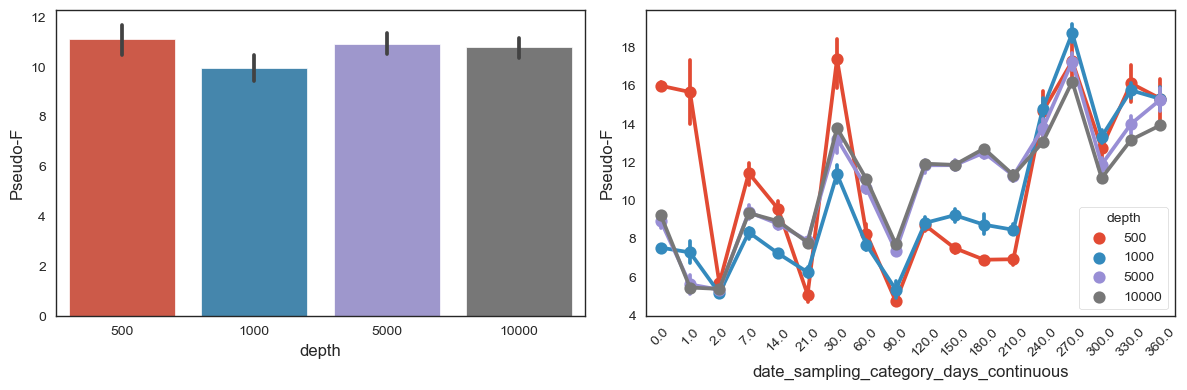

In [97]:
sns.set_style('white')
fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
sns.barplot(x=experiment, y='test statistic', data=permanova_results_df, 
            ci=68, ax=axn[0])
axn[0].set_facecolor('white')
axn[0].set_xlabel(experiment)
axn[0].set_ylabel('Pseudo-F')
sns.pointplot(x=state_column, hue=experiment, y='test statistic', 
              data=permanova_results_df, ci=68, ax=axn[1])
axn[1].set_facecolor('white')
axn[1].set_ylabel('Pseudo-F')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PC1
Depth:  500
Eigenvalues:
      component_1  component_2  component_3
16S   855.872546   316.138186   249.455224

Explained variance:
                component_1  component_2  component_3
var_explained     0.672544     0.237188     0.090268

Depth:  1000
Eigenvalues:
      component_1  component_2  component_3
16S   981.533198   766.443578   301.318895

Explained variance:
                component_1  component_2  component_3
var_explained      0.52255     0.355298     0.122152

Depth:  5000
Eigenvalues:
      component_1  component_2  component_3
16S   804.621713   710.734361   403.784936

Explained variance:
                component_1  component_2  component_3
var_explained     0.466379     0.346594     0.187027

Depth:  10000
Eigenvalues:
      component_1  component_2  component_3
16S   827.406264   749.243232   458.088932

Explained variance:
                component_1  component_2  component_3
var_explained     0.466892     0.338958      0.19415



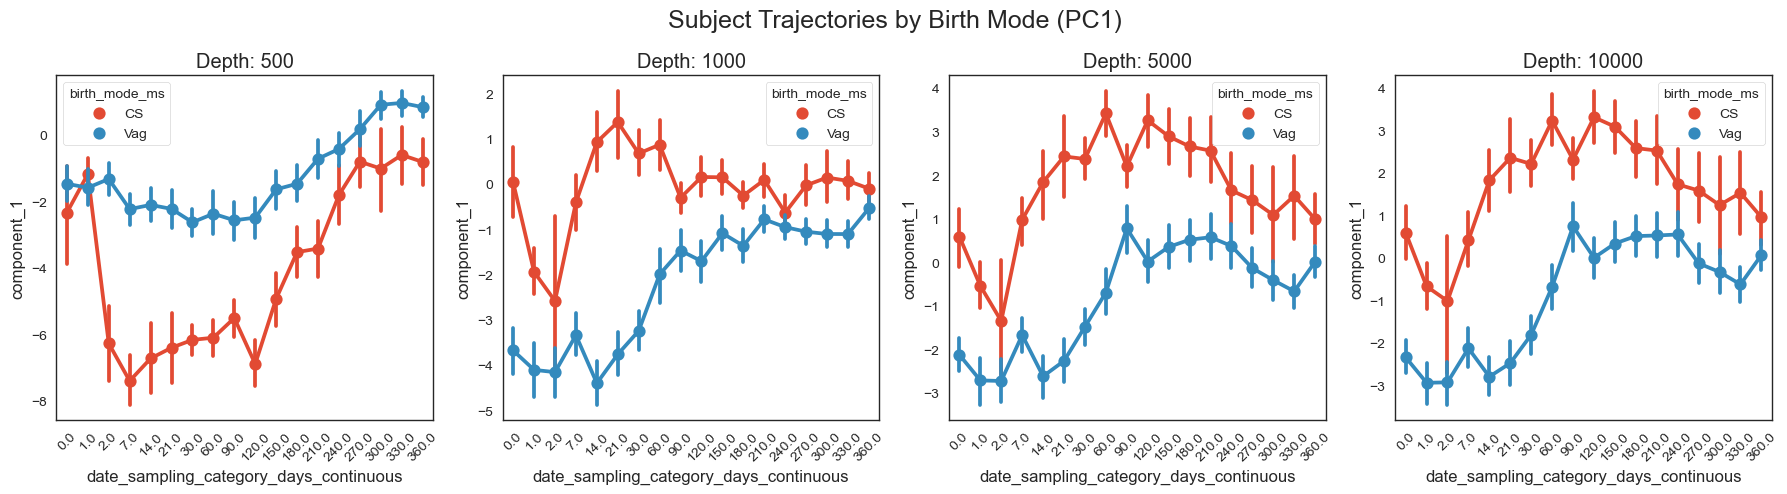

PC2
Depth:  500
Eigenvalues:
      component_1  component_2  component_3
16S   855.872546   316.138186   249.455224

Explained variance:
                component_1  component_2  component_3
var_explained     0.672544     0.237188     0.090268

Depth:  1000
Eigenvalues:
      component_1  component_2  component_3
16S   981.533198   766.443578   301.318895

Explained variance:
                component_1  component_2  component_3
var_explained      0.52255     0.355298     0.122152

Depth:  5000
Eigenvalues:
      component_1  component_2  component_3
16S   804.621713   710.734361   403.784936

Explained variance:
                component_1  component_2  component_3
var_explained     0.466379     0.346594     0.187027

Depth:  10000
Eigenvalues:
      component_1  component_2  component_3
16S   827.406264   749.243232   458.088932

Explained variance:
                component_1  component_2  component_3
var_explained     0.466892     0.338958      0.19415



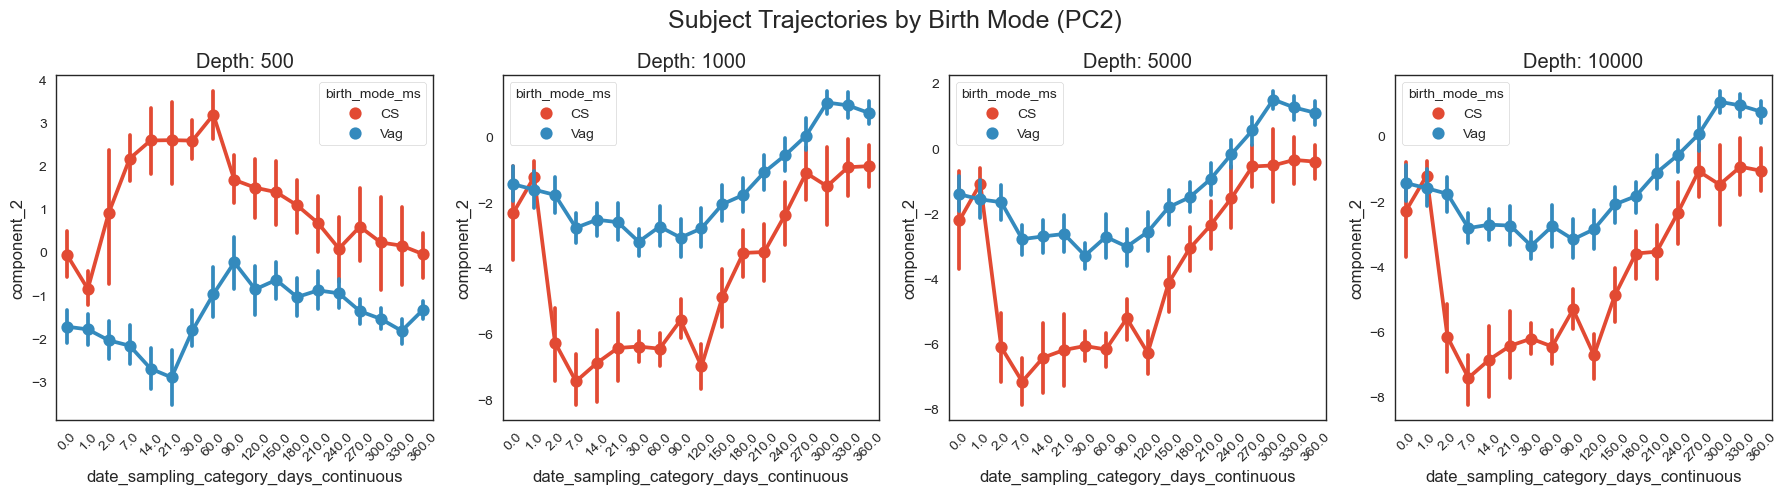

PC3
Depth:  500
Eigenvalues:
      component_1  component_2  component_3
16S   855.872546   316.138186   249.455224

Explained variance:
                component_1  component_2  component_3
var_explained     0.672544     0.237188     0.090268

Depth:  1000
Eigenvalues:
      component_1  component_2  component_3
16S   981.533198   766.443578   301.318895

Explained variance:
                component_1  component_2  component_3
var_explained      0.52255     0.355298     0.122152

Depth:  5000
Eigenvalues:
      component_1  component_2  component_3
16S   804.621713   710.734361   403.784936

Explained variance:
                component_1  component_2  component_3
var_explained     0.466379     0.346594     0.187027

Depth:  10000
Eigenvalues:
      component_1  component_2  component_3
16S   827.406264   749.243232   458.088932

Explained variance:
                component_1  component_2  component_3
var_explained     0.466892     0.338958      0.19415



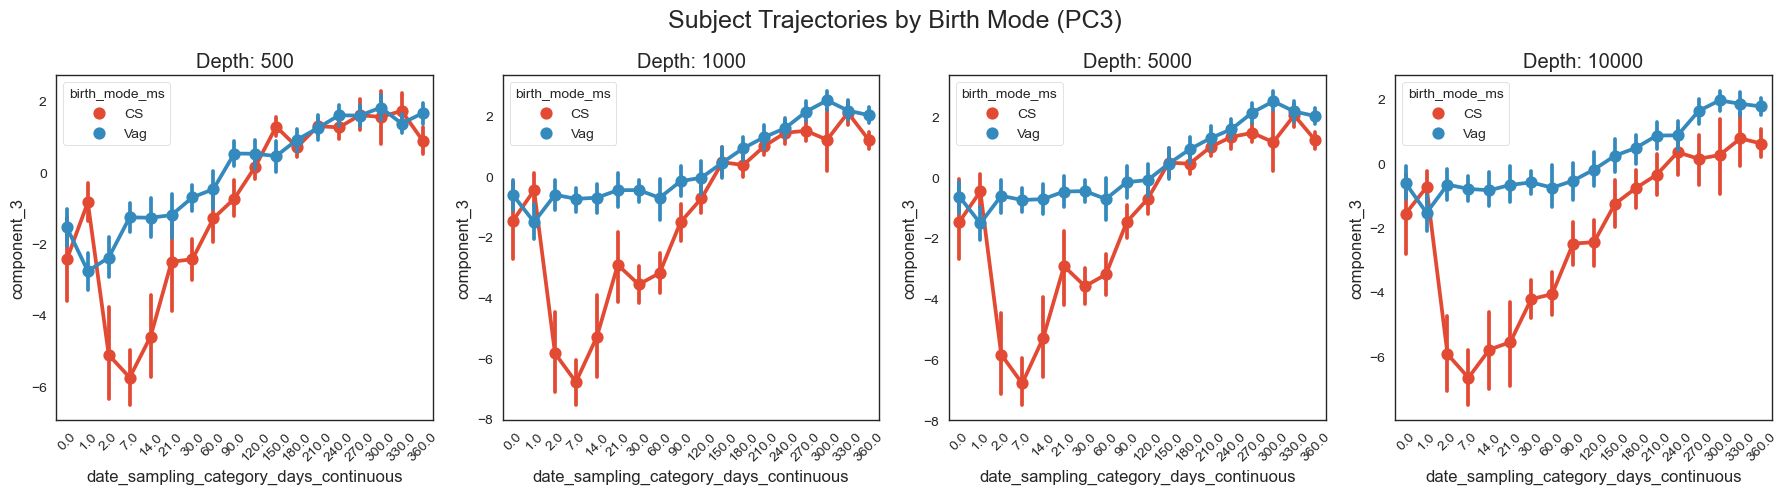

In [98]:
fold_ = 1
depth = 10000
test_title = 'Depth'
state_column = 'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'

cols = sorted(set([int(k[0]) for k in sim_results_depth.keys()]))
#cols = sorted(set([int(k[1]) for k in sim_results_disp.keys()]))
mf_subject_collapsed = mf_to_use.groupby(subject_id_column).agg({cat_of_interest:'first'})

for ci, component in enumerate(['component_1', 'component_2', 'component_3']):
    
    fig, axn = plt.subplots(1, len(cols), figsize=(18, 5))
    
    print('PC{}'.format(ci+1))

    for i, exp_ in enumerate(cols):
        #(ind_loads, feat_loads, state_loads, 
        # lambdas, var_explained, _) = sim_results_disp[(depth, exp_, fold_)]
        (ind_loads, feat_loads, state_loads, 
         lambdas, var_explained, _) = sim_results_depth[(exp_, fold_)]
        
        print('{}: '.format(test_title), exp_)
        print('Eigenvalues:\n', lambdas)
        print()
        print('Explained variance:\n', var_explained.T)
        print()

        beta_l, _, _ = subject_trajectories(bt, feat_loads, component=component,
                                            modality='16S', pseudocount=0.5, quantile=0.95)
        #map dates and category of interest from mf
        beta_l[state_column] = beta_l.index.map(mf_to_use[state_column])
        beta_l[cat_of_interest] = beta_l.index.map(mf_to_use[cat_of_interest])
        sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                    data=beta_l, ax=axn[i], ci=68)
        axn[i].set_title('{}: {}'.format(test_title, exp_))
        axn[i].set_facecolor('white')
        xlabels = axn[i].get_xticklabels()
        axn[i].set_xticklabels(xlabels, rotation=45)
        
    plt.suptitle('Subject Trajectories by Birth Mode (PC{})'.format(ci+1), fontsize=18)
    plt.tight_layout()
    plt.show()

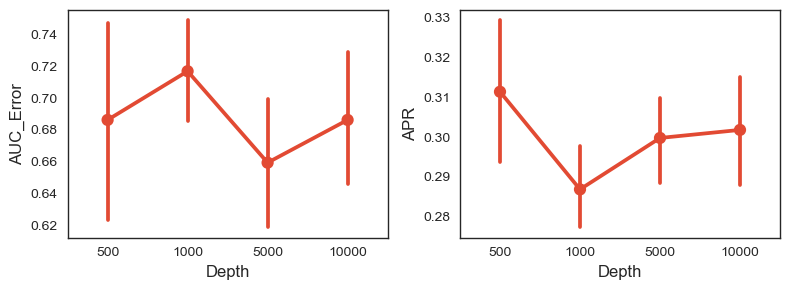

In [99]:
test_title = 'Depth'
n_splits = 20
mf_subject_collapsed = mf_to_use.groupby(subject_id_column).agg({cat_of_interest:'first'})
#initialize df with metrics
metrics_df = pd.DataFrame(columns=['AUC_Error', 'APR', test_title])

for i, exp_ in enumerate(cols):
    #ind_loads, _, _, _, _, _ = sim_results_disp[(depth, exp_, fold_)]
    ind_loads, _, _, _, _, _ = sim_results_depth[(exp_, fold_)]

    #set up the classifier
    knn = KNeighborsClassifier(n_neighbors=2)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    X = ind_loads['16S'][['component_1', 'component_2', 'component_3']].copy()
    y = X.index.map(mf_subject_collapsed[cat_of_interest])
    X = X.values
    
    auc_error = []
    apr = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        y_proba = knn.predict_proba(X_test)

        #ROC AUC
        y_test_binary = [0 if x == "Vag" else 1 for x in y_test]
        fpr, tpr, _ = roc_curve(y_test_binary, y_proba[:,1])
        auc_error.append(1-auc(fpr, tpr))
        #APR
        apr.append(average_precision_score(y_test_binary, y_proba[:,1]))

    #create df with metrics
    metrics_df_iter = pd.DataFrame({'AUC_Error':auc_error, 'APR':apr}, index=range(n_splits))
    metrics_df_iter[test_title] = exp_

    #stack the metrics
    metrics_df = pd.concat([metrics_df, metrics_df_iter])

fig, axn = plt.subplots(1, 2, figsize=(8, 3))
sns.pointplot(x=test_title, y='AUC_Error', data=metrics_df, ax=axn[0], ci=68)
sns.pointplot(x=test_title, y='APR', data=metrics_df, ax=axn[1], ci=68)
plt.tight_layout()
plt.show()

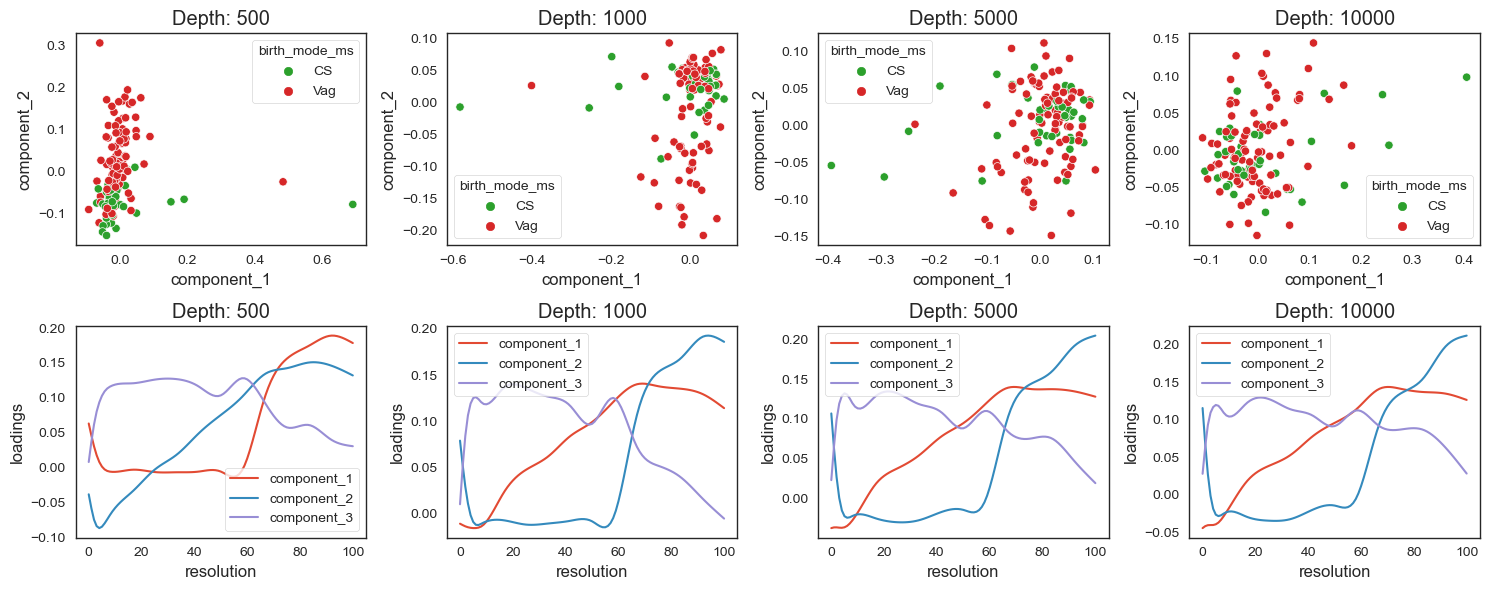

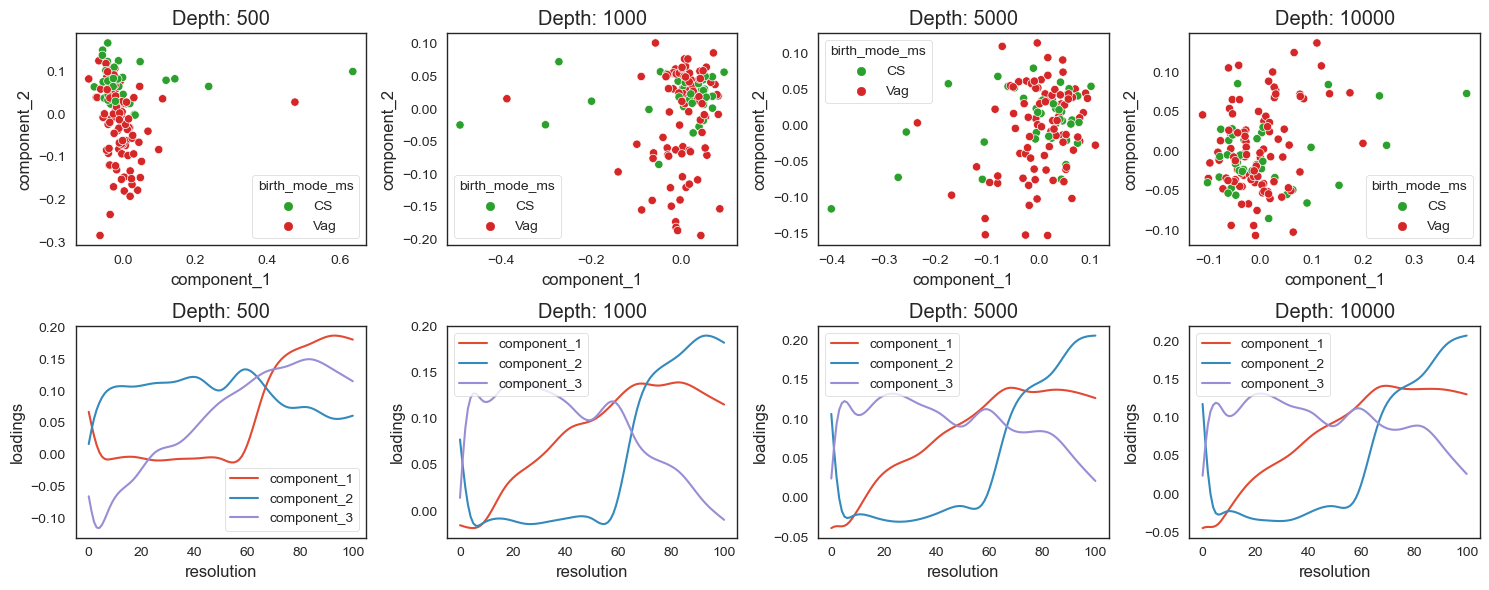

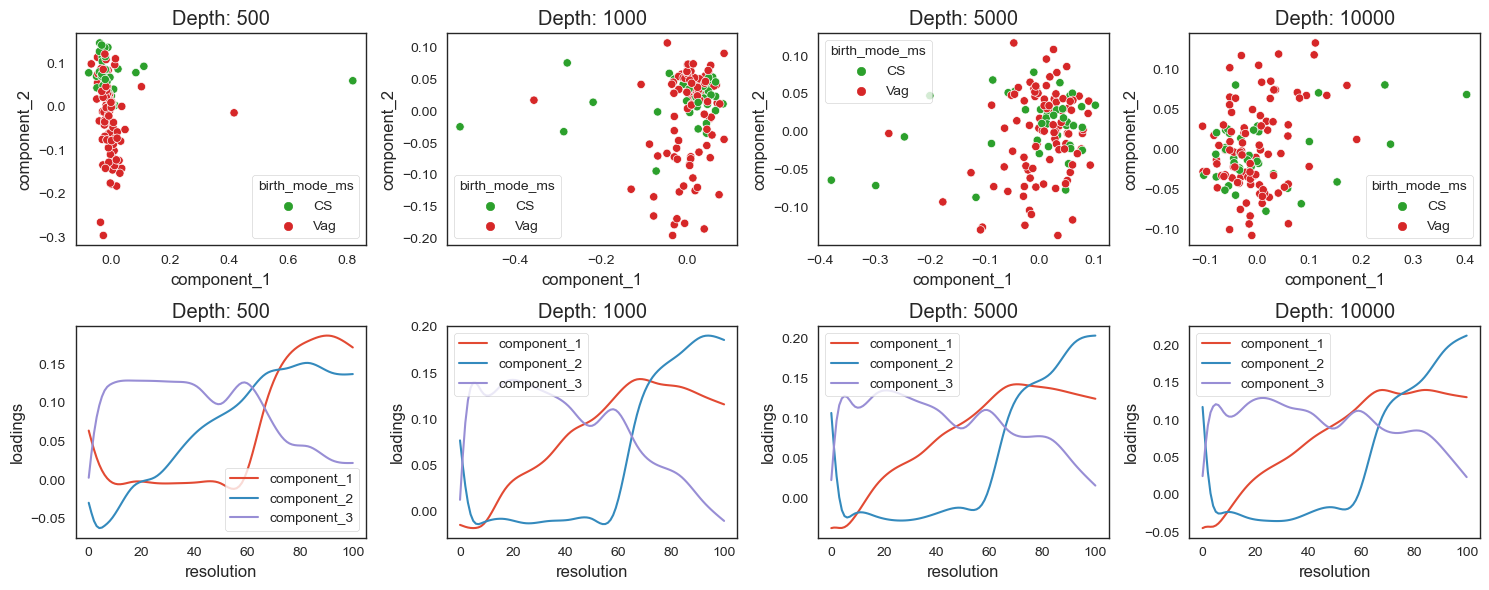

In [100]:
sns.set_style('white')
for fold_ in range(3):

    cols = sorted(set([int(k[0]) for k in sim_results_depth.keys()]))
    #cols = sorted(set([int(k[1]) for k in sim_results_disp.keys()]))
    fig, axn = plt.subplots(2, len(cols), figsize=(15, 6))
    mf_subject_collapsed = mf_to_use.groupby(subject_id_column).agg({cat_of_interest:'first'})
    group_colors = {'Vag': 'tab:red', 'CSseed': 'tab:blue', 'CS': 'tab:green'}
    comp1 = 'component_1'
    comp2 = 'component_2'

    for i, exp in enumerate(cols):
        ind_loads, _, state_loads, _, _, _ = sim_results_depth[(exp, fold_)]
        #ind_loads, _, state_loads, _, _, _ = sim_results_disp[(depth, exp, fold_)]
        sns.scatterplot(x=ind_loads['16S'][comp1], 
                        y=ind_loads['16S'][comp2],  
                        hue=mf_subject_collapsed[cat_of_interest], 
                        palette=group_colors, ax=axn[0,i])
        axn[0,i].set_title('{}: {}'.format(test_title, exp))

        sns.lineplot(data=state_loads['16S'][['component_1', 'component_2', 'component_3']], 
                     ax=axn[1,i], dashes=False)
        axn[1,i].set_title('{}: {}'.format(test_title, exp))
        axn[1,i].legend() 
        axn[1,i].set_xlabel('resolution')         
        axn[1,i].set_ylabel('loadings') 

    plt.tight_layout()
    plt.show()

In [101]:
# simulation_results_ctf = {}
# for k_sim, bt_tmp in tqdm(simulations_depth.items()):
#     print(k_sim)
#     # run CTF (can re-filter to what you might do normally)
#     simulation_results_ctf[k_sim] = ctf(bt_tmp.copy(), mf, 
#                                         subject_id_column,
#                                         state_column,
#                                         min_sample_count=0)